# Clothing Material and Heat Transfer

Kristtiya Guerra and Audrey Lee

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Question
We wanted to determine which clothing combinations were best to wear during the average winter temperature in Boston. We did not want to approach through comparing clothing designed for the cold. We wanted to experiment with different combinatinations that exist excluding weather conditions. A study was done in the late 70s through early 80s, and was published in the early 90s, that calculated the col values of different clothing articles based on categories such as shirt, trouser, socks, and dresses. 


Our model and question went through a few iterations. Initially we were going to make the approach of looking at the insulation of individual materials used in clothing, however we deemed that inefficent compared to using the clothing and surface area. 

### Model : Clothing Combinations and Heat Loss


I will set  `State` objects for the initial temperature of the human body (in Kelvin), the heat loss, which is initially 0, and the r-values and surface areas of each clothing piece. We made multiple states, which each represented a clothing style. 
The units were also implemented in this portion. They were added individually in each state object.

In [2]:
Meter = UNITS.meter
Watt = UNITS.watt
Second = UNITS.second
Kelvin = UNITS.kelvin
Celsius = UNITS.celsius
Joules = UNITS.joules
RUnit = Kelvin * Meter * Meter / Watt
ASqr = Meter * Meter

HumanArea = 1.6 * ASqr #Creating the surface area of a human
HumanTemp = (37 + 273.15) * Kelvin #Creating the acerage human body temperature

#### Creating State Objects for each clothing combination ####

WinterInit = State(HumanTemp=HumanTemp, Q = 0*Watt,  
                   top =0.41/1.136 * RUnit, bottom=0.21/1.136 * RUnit, socks=0.04/1.136 * RUnit, rHuman=.003874*RUnit,
                   Atop=1.6*.47*ASqr, Abottom=1.6*.45*ASqr, Asocks=1.6*.07*ASqr)

SummerInit = State(HumanTemp=HumanTemp, Q = 0*Watt, 
                   top =0.07/1.136* RUnit, bottom=0.09/1.136* RUnit, socks=0.03/1.136* RUnit, rHuman=.003874* RUnit,
                   Atop=1.6*.12*ASqr, Abottom=1.6*.18*ASqr, Asocks=1.6*.05*ASqr)

LoungeInit = State(HumanTemp=HumanTemp, Q = 0*Watt, 
                   top =0.38/1.136* RUnit, bottom=0.34/1.136* RUnit, socks=0.03/1.136* RUnit, rHuman=.003874* RUnit,
                   Atop=1.6*.45*ASqr, Abottom=1.6*.44*ASqr, Asocks=1.6*.07*ASqr)

DressInit = State(HumanTemp=HumanTemp, Q = 0*Watt, 
                   top =0.83/1.136* RUnit, bottom=0.59/1.136* RUnit, socks=0.02/1.136* RUnit, rHuman=.003874* RUnit,
                   Atop=1.6*.40*ASqr, Abottom=1.6*.19*ASqr, Asocks=1.6*.35*ASqr)

SleeperInit = State(HumanTemp=HumanTemp, Q = 0*Watt, 
                   top =0.92/1.136* RUnit, bottom=1* RUnit, socks=1* RUnit, rHuman=.003874* RUnit,
                   Atop=1.6*.86*ASqr, Abottom=1.6*0*ASqr, Asocks=1.6*0*ASqr)

,values
HumanTemp,310.15 kelvin
Q,0 watt
top,0.8098591549295776 kelvin * meter ** 2 / watt
bottom,1 kelvin * meter ** 2 / watt
socks,1 kelvin * meter ** 2 / watt
rHuman,0.003874 kelvin * meter ** 2 / watt
Atop,1.3760000000000001 meter ** 2
Abottom,0.0 meter ** 2
Asocks,0.0 meter ** 2


And a `System` object to contain the system parameters. The state object values for the clothing combinations are also implemented into the state object, as they also become a system containing the heat loss. We also set the temperature of the outside, choosing 5 degrees celsius as that is the center point of Boston's average high and low temperature in the winter.

For the time range, we chose 30 minutes, but it can be replaced with any number if wanted. That means it will equal to 1800 seconds as 

In [58]:
human = System(WinterInit=WinterInit, 
               SummerInit=SummerInit,
               LoungeInit=LoungeInit,
               DressInit=DressInit,
               SleeperInit=SleeperInit,
               T_env= (5+273.15) * Kelvin,
               t_end=1800,
               dt=1)

,values
WinterInit,HumanTemp ...
SummerInit,HumanTemp ...
LoungeInit,HumanTemp ...
DressInit,HumanTemp ...
SleeperInit,HumanTemp 3...
T_env,278.15 kelvin
t_end,1800
dt,1


The update function here, title as "Clothes" gathers the state values from the clothing combination systems. The equation is an interpretation that came from the paper mentioned. It takes the surface area covered by the clothing multiplied by the difference in the temperature outside compared to the human body temperature, and divided by the r-value of the clothing. The equation is then multiplied by time to represent the loss of heat energy over time.

In [59]:
def Clothes(state, t, system):
    """Update the thermal transfer model.
    
    state: State (temp)
    t: time
    system: System object
    
    returns: State (temp)
    """
    unpack(system)
    
    HumanTemp, Q, top, bottom, socks, rHuman, Atop, Abottom, Asocks = state
    T_delta = HumanTemp-T_env
    dQdt = ((Atop * (T_delta)/top) + (Abottom * (T_delta)/bottom) + (Asocks * (T_delta)/socks)
                  + (((1.6 * ASqr)-(Atop+Abottom+Asocks)) * T_delta/rHuman))
    Q += dQdt *dt

    return State(HumanTemp=HumanTemp, Q=Q, 
                 top=top, bottom=bottom, socks=socks, rHuman=rHuman, Atop=Atop, Abottom=Abottom, Asocks=Asocks)

Our Run simulation works by running the same equation, but by sweeping through the different
clothing combinations and their parameters. 

In [60]:
def run_simulation(system, Clothes):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    unpack(system)
    
    frame = TimeFrame(columns=WinterInit.index)
    frame2 = TimeFrame(columns=SummerInit.index)
    frame3=TimeFrame(columns=LoungeInit.index)
    frame4=TimeFrame(columns=DressInit.index)
    frame5=TimeFrame(columns=SleeperInit.index)
    
    frame.row[0] = WinterInit
    frame2.row[0] = SummerInit
    frame3.row[0] = LoungeInit
    frame4.row[0] = DressInit
    frame5.row[0] = SleeperInit
    
    ts = linrange(0, t_end, dt)
    
    for t in ts:
        frame.row[t+dt] = Clothes(frame.row[t], t, system)
        frame2.row[t+dt] = Clothes(frame2.row[t],t,system)
        frame3.row[t+dt] = Clothes(frame3.row[t],t,system)
        frame4.row[t+dt] = Clothes(frame4.row[t],t,system)
        frame5.row[t+dt] = Clothes(frame5.row[t],t,system)
        
    # store the final temperature in T_final for each clothing combination
    system.T_final = get_last_value(frame.Q)
    system.T_final2 = get_last_value(frame2.Q)
    system.T_final3 = get_last_value(frame3.Q)
    system.T_final4 = get_last_value(frame4.Q)
    system.T_final5 = get_last_value(frame5.Q)
    
    return frame, frame2, frame3, frame4, frame5

In [61]:
results = run_simulation(human, Clothes);


## Results 1:  Surface Area of Clothing Coverage versus r Values

### R Value versus Area Clothing Coverage

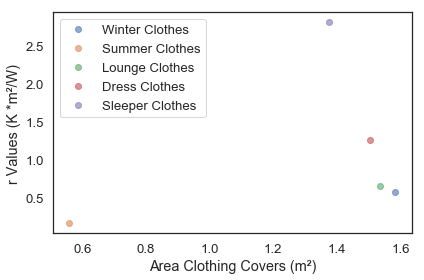

In [62]:
rValueResult = []
AreaResult = []
for tClothing in range(0,5):    
    rValueResult += [results[tClothing].top[0] + results[tClothing].bottom[0] + results[tClothing].socks[0]]
    AreaResult += [results[tClothing].Atop[0] + results[tClothing].Abottom[0] + results[tClothing].Asocks[0]]
plot(AreaResult[0], rValueResult[0], 'o', label='Winter Clothes')
plot(AreaResult[1], rValueResult[1], 'o', label='Summer Clothes')
plot(AreaResult[2], rValueResult[2], 'o', label='Lounge Clothes')
plot(AreaResult[3], rValueResult[3], 'o', label='Dress Clothes')
plot(AreaResult[4], rValueResult[4], 'o', label='Sleeper Clothes')
decorate(xlabel='Area Clothing Covers (m²)',
        ylabel='r Values (K *m²/W)')


The figure shows the total r-value of the clothing combinations compared to the total surface area of coverage by the outfits. In comparison with Figure 2, based on the results it can be concluded that while r-value is significant in affecting the clothing insulation, the most important factor for determining heat loss is the surface area coverage.

This model works at showing r-values however the way it fails is it only adds the r-values, rather than come up with some sort of average however that method also does not exist so there is no way to verify if it could give significant information.


## Results 2: Heat Loss over Time

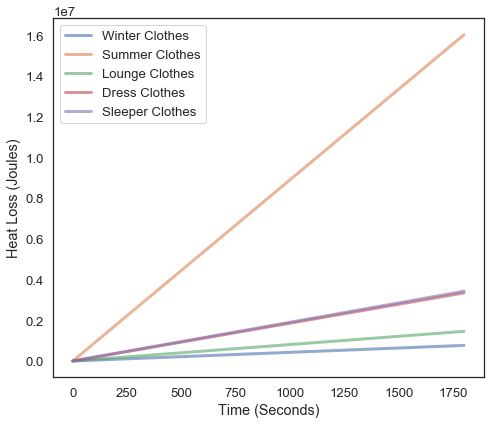

In [66]:
plt.figure(figsize=(7,6))
plot(results[0].Q, label='Winter Clothes')
plot(results[1].Q, label='Summer Clothes')
plot(results[2].Q, label='Lounge Clothes')
plot(results[3].Q, label='Dress Clothes')
plot(results[4].Q, label='Sleeper Clothes')

decorate(xlabel='Time (Seconds)',
         ylabel='Heat Loss (Joules)')

The Figure above shows the comparison of heat loss over time of different clothing types. Based on the results, it can be concluded that winter clothes is the most efficient to wear in the winter temperatures, however an alternative could also be lounge gear, which consists of a sweatshirt, sweatpants, and athletic socks. They have close to the same heat loss trend as the winter clothing.

The model works well at showing the trend of heat loss over time, however what it fails at is looking at temperature loss over time (in Kelvin), and taking into account of wind-chill. We did make an attempt to convert the value Q to temperature but that involved more constants such as the mass of a person, which would make the model less general to all humans.

### The below above show the total final heat loss is watts of each simulated person wearing their respected clothing combinations.

In [65]:
human.T_final

<Quantity(765466.299451561, 'watt')>

In [54]:
human.T_final2

<Quantity(267107.3230910833, 'watt')>

In [55]:
human.T_final3

<Quantity(24255.425581354426, 'watt')>

In [56]:
human.T_final4

<Quantity(55727.874393375445, 'watt')>

In [57]:
human.T_final5

<Quantity(57139.616762092905, 'watt')>

The data above shows the final amount of heat loss that occured over time

### Heat Loss of Dress Clothing Compared to Heat Loss of Sleeper Clothing


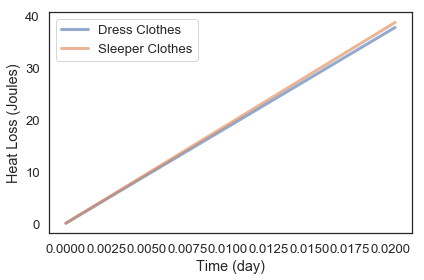

In [46]:
plt.figure(figsize=(6,4))
plot(results[3].Q, label='Dress Clothes')
plot(results[4].Q, label='Sleeper Clothes')
decorate(xlabel='Time (day)',
         ylabel='Heat Loss (Joules)')

The figure above plots the heat loss of the dress clothes and the sleeper clothes. We plotted them individually here just so we could see the differences between their trends as both were very similar. The dress clothes appear to have less heat loss comapred to the sleeper outfit, which infers that it is much better to wear a dress outside compared to a full-body sleeper.

## Results 3: Heat Loss of Each Clothing Combination

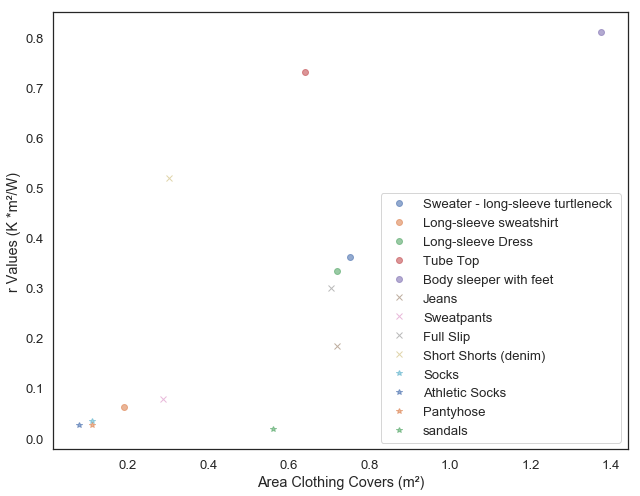

In [15]:
plt.figure(figsize=(9,7))
RValue = []
SurfaceCoverage = []
for tClothing in range(0,5):    
    RValue +=  [results[tClothing].top[0]]
    SurfaceCoverage +=    [results[tClothing].Atop[0]]
plot(SurfaceCoverage[0], RValue[0], 'o', label='Sweater - long-sleeve turtleneck ')
plot(SurfaceCoverage[1], RValue[1], 'o', label='Long-sleeve sweatshirt')
plot(SurfaceCoverage[2], RValue[2], 'o', label='Long-sleeve Dress')
plot(SurfaceCoverage[3], RValue[3], 'o', label='Tube Top')
plot(SurfaceCoverage[4], RValue[4], 'o', label='Body sleeper with feet')
RValue = []
SurfaceCoverage = []
for tClothing in range(0,5):    
    RValue +=  [results[tClothing].bottom[0]]
    SurfaceCoverage +=    [results[tClothing].Abottom[0]]
plot(SurfaceCoverage[0], RValue[0], 'x', label='Jeans')
plot(SurfaceCoverage[1], RValue[1], 'x', label='Sweatpants')
plot(SurfaceCoverage[2], RValue[2], 'x', label ='Full Slip')
plot(SurfaceCoverage[3], RValue[3], 'x', label='Short Shorts (denim)')
RValue = []
SurfaceCoverage = []
for tClothing in range(0,5):    
    RValue +=  [results[tClothing].socks[0]]
    SurfaceCoverage +=    [results[tClothing].Asocks[0]]
plot(SurfaceCoverage[0], RValue[0], '*', label='Socks')
plot(SurfaceCoverage[1], RValue[1], '*', label='Athletic Socks')
plot(SurfaceCoverage[2], RValue[2], '*', label='Pantyhose')
plot(SurfaceCoverage[3], RValue[3], '*', label='sandals')
decorate(xlabel='Area Clothing Covers (m²)',
        ylabel='r Values (K *m²/W)')

### Abstract

Our question was which clothing combination was best to wear during the average winter temperatures in Boston. Based on the model, it can be inferred that the Winter Clothing consisting of a long-sleeve, thick knit, turtleneck sweater, straight fit denim pants, and dress socks. Another inference made was that wearing sweatclothes (louge clothing) was nearly just as good as wearing the winter clothing.
(well labeled figures?)

